# 3. Model tests
## 3.04 Example: XGBoost

Process outline
1. Prepare time delay features
2. Spatial aggregation
   - Area weighted sum for precipitation features
   - Area mean for all other features
3. Define the model
4. Train the model
   - Reshape the input dataset to the model specific `X` and `y` arrays
   - Actually train on `X` and `y`

In [1]:
import sys
sys.path.append("../../")
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask
dask.config.set(scheduler='threads')
import xarray as xr
sys.path.append("../../")
from python.aux.utils_floodmodel import reshape_multiday_predictand
from python.aux.utils_floodmodel import add_future_vars
from python.aux.verification import verify, ME, RMSE, RMSE_persistence, NSE, NSE_diff

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [3]:
# load data
version = 'v1'

if version == 'v1':
    features = xr.open_dataset('../../data/features_xy.nc')
    y = features['dis']
    X = features.drop(['dis'])
elif version == 'v2':
    features = xr.open_dataset('../../data/features_xy_v2.nc')
    y = features['dis']
    X = features.drop(['dis', 'dis_diff'])

In [4]:
features

<xarray.Dataset>
Dimensions:     (time: 5478)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude    float64 ...
    longitude   float64 ...
Data variables:
    cp          (time) float64 ...
    lsp         (time) float64 ...
    swvl1       (time) float64 ...
    ro          (time) float64 ...
    sd          (time) float64 ...
    lsp-1       (time) float64 ...
    lsp-2       (time) float64 ...
    lsp-3       (time) float64 ...
    lsp-4-10    (time) float64 ...
    lsp-11-24   (time) float64 ...
    lsp-25-54   (time) float64 ...
    lsp-55-180  (time) float64 ...
    cp-1        (time) float64 ...
    cp-2        (time) float64 ...
    cp-3        (time) float64 ...
    sd_diff     (time) float64 ...
    dis         (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [5]:
dis_shift_switch = False

In [6]:
abs_vals_switch = False

Begin with some short preprocessing..

In [7]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [8]:
X_base = X.to_array(dim='features').T
y_base = y

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [9]:
period_train = dict(time=slice(None, '1990'))
period_valid = dict(time=slice('1991', '1993'))
period_test = dict(time=slice('1994', '1995'))

In [10]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [11]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series."""
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [12]:
X_train.shape, y_train.shape

((3652, 16), (3652,))

In [13]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [14]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Define boosting regressor

In [15]:
model = GradientBoostingRegressor(n_estimators=100,
                                  learning_rate=0.1,
                                  max_depth=10,
                                  random_state=0,
                                 # loss='ls'
                                 )

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   2.8s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=10,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                     

model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6),
                          n_estimators=400)


pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),],
                verbose=True)

pipe.fit(Xda, yda)

### in sample test for the predicted change, to verify functionality

In [16]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

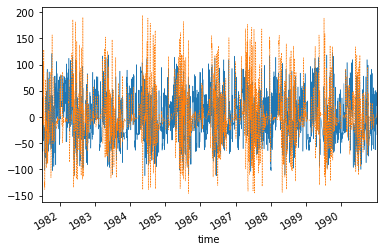

In [17]:
insample_check = pipe.predict(Xda)
insample_check = add_time(insample_check, Xda.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

Set the frequency at which forecast are started.

In [18]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n]
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)
# clean vars
del pipe
del model

<xarray.DataArray 'forecast' (time: 1096)>
array([ 16.162182,  24.768242,  14.868304, ..., -12.091209, -16.616733,
       -19.746434])
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1993-12-31


In [25]:
def plot_pred_series(x, y, y_truth, forecast_range=14):
    """Convenience function for converting the prediction output in xr.DataArray with the sa"""
    # assuming x has a resolution of 1 day, else a key error will result.
    dt = x.time[1]-x.time[0]
    # create prediction series containing nans
    pred = x.copy().isel(features=0)*np.nan
    # rename and drop unnecessary stuff
    pred.name = 'prediction'
    pred = pred.drop('features')
    # add truth at time t=t0 for each forecast
    y_steps = y[1::forecast_range].copy()
#    print(pred)
    pred.loc[y_steps.time-dt] = y_truth.loc[y_steps.time-dt]
    pred.loc[y_steps.time] = y_steps + pred.loc[y_steps.time-dt].values
    
    # add multiple forecast days onto prediction
    yinit = x.time.dt.year[0].values
    tinit = f"{yinit}-01-01"
    yend = x.time.dt.year[-1].values
    tend = f"{yend}-12-31"
    time_vec = y_steps.time.copy()
    for i in range(1, forecast_range-2):
        tind = (y_steps.time+dt*i).sel(time=slice(tinit, tend))
        try: # easy way to ignore indexing out of the date range, happens only at the jump upwards of the boundary
            pred.loc[tind] = y.loc[tind] + pred.loc[tind-dt].values
        except:
            pred.loc[tind[:-1]] = y.loc[tind[:-1]] + pred.loc[tind[:-1]-dt].values
    
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': x.time}).to_pandas().plot(ax=ax, label='truth')
    pred.to_pandas().plot(ax=ax, label='forecast')
    plt.legend()
    ax.set_ylabel('river discharge [m$^3$/s]')
    return pred

In [29]:
print(y_valid)

<xarray.DataArray 'dis' (time: 1096)>
array([ 602.04248 ,  609.904907,  632.579773, ..., 1132.167725, 1123.2948  ,
       1120.796753])
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1993-12-31
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    long_name:  discharge
    units:      m3/s


Text(0.5, 1.0, 'Setting: GradientBoostingRegressor: n_estimators=100; learning_rate=0.1; max_depth=5 |\xa0RMSE=192.04; NSE=0.88')

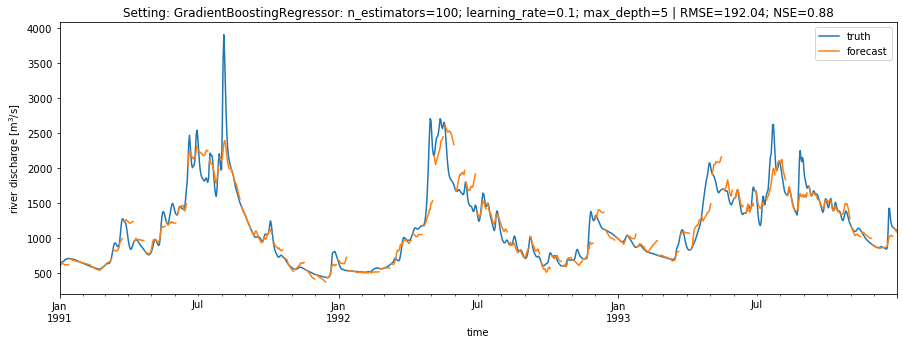

In [30]:
pred = plot_pred_series(X_pred, y_pred, y, forecast_range=14)

# calculate RMSE and NSE and put it in the plot title
# differences
#y_o = y_valid.diff(dim='time')
#y_m = y_pred.where(y_o, drop=True)
# absolute values
y_o = y_valid
y_m = pred

rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

plt.title(f"Setting: GradientBoostingRegressor: n_estimators=100; learning_rate=0.1; max_depth=5 | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)}")

#### Check the skill of a 14-day persistence forecast:

In [43]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=251.09; NSE=0.77


For a more easy hyperparameter optimization procedure, let us define the following convenience function.

### NOTE: The following function is not used, because it seems that redefining the model/pipe in the same jupyter notebook leads to some errors (in output, not on the technical side; verified with single calls from a script). Therefor, this only serves as examplary function, on how one can call the booster from a script to generate the relevant output for the hyperparameter optimization! The following pictures further down are generated this way.

def opti_boost_reg(x_train, y_train, x_valid, y_valid, y_truth, plot_insample_check=None,
                   boost_type='gradient', n_est=400, lr=0.2, max_depth=10):
    """Convenience function for the use of boostingRegressor with easy to use settings to determine hyperparameters.
    
    Parameters
    ----------
    boost_type : str
                'gradient' for GradientBoostingRegressor
                'ada'      for AdaBoostRegressor
    n_est      : int
                number of estimators
    lr         : float
                learning rate
    max_depth  : int
                max depth of trees
    x_train    : xr.DataArray
                features for training
    y_train    : xr.DataArray
                predictand for training
    x_valid    : xr.DataArray
                features for validation
    y_valid    : xr.DataArray
                predictand for validation
    y_truth    : xr.DataArray
                reanalysis data
    plot_insample_check : Bool
                If True, an in sample prediction will be plotted and compared to the true change in discharge
    """
    
    if boost_type == 'gradient':
        model_opti = GradientBoostingRegressor(n_estimators=n_est,
                                               learning_rate=lr,
                                               max_depth=max_depth,
                                               random_state=0,
                                               loss='ls')
    elif boost_type == 'ada':
        model_opti = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                                       n_estimators=n_est)
        
    # define pipe    
    pipe_opti = Pipeline([('scaler', StandardScaler()),
                          #('pca', PCA(n_components=6)),
                          ('model', model_opti),],
                         verbose=True)
    
    # fit pipe
    pipe_opti.fit(x_train, y_train)
    
    if plot_insample_check:
        insample_check = pipe_opti.predict(x_train)
        insample_check = add_time(insample_check, x_train.index, name='forecast')
        insample_check.to_pandas().plot(linewidth=0.5)
        y_train.plot(linestyle='--', linewidth=0.5)

    # predict
    # prediction start from every nth day; EXPERIMENTAL: leave at 1 if in doubt
    n = 1
    x_pred = x_valid[::n]
    y_pred = pipe_opti.predict(x_pred)

    y_pred = add_time(y_pred, x_pred.time, name='forecast')

    # call the plotting routine
    plot_pred_series(x_pred, y_pred, y_truth, forecast_range=14)
    
    # calculate some verification metrics
    y_o = y_valid
    y_m = pred

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))


    # and put them in the title
    plt.title(f"Setting: n_estimators={n_est}; learning_rate={lr}; max_depth={max_depth} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)}")
    
    del model_opti
    del pipe_opti
    plt.savefig(f'../../archive/figures/{n_est}_{lr}_{max_depth}.png')
    return None

Load figures generated via the script as explained above:

### 1) fix `n_estimators` and `learning_rate` => examine `max_depth`:

![](../../archive/figures/50_0.1_3.png)
![](../../archive/figures/50_0.1_6.png)
![](../../archive/figures/50_0.1_10.png)

This result is consistent with other combinations of `n_estimators` and `learning_rate` as well, suggesting the sweet spot for the `max_depth` per tree is 6.

### 2) fix `learning_rate` and `max_depth` => examine `n_estimators`:

![](../../archive/figures/50_0.1_6.png)
![](../../archive/figures/200_0.1_6.png)
![](../../archive/figures/300_0.1_6.png)

Best result: `n_estimators=200`

### 3) fix `n_estimators` and `max_depth` => examine `learning_rate`:

![](../../archive/figures/200_0.05_6.png)
![](../../archive/figures/200_0.1_6.png)
![](../../archive/figures/200_0.2_6.png)

Best result: `learning_rate=0.1`

#### Note that a lot more combinations were tested, but are not listed as figures for brevity sake. In the following table all of the results are shown. In general, the different settings show very close validation metrics, suggesting robustness, nevertheless, we will continue with the formal best setting for the model comparison.

|   varying param   |   n_estimators   |   learning_rate   |   max_depth   |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | :-----: | :-----: | :-----: |
| `max_depth` | 50 | 0.1 | 1 | 217.72 | 0.84 |
| `max_depth` | 50 | 0.1 | 2 | 206.27 | 0.86 |
| `max_depth` | 50 | 0.1 | 3 | 191.52 | 0.88 |
| `max_depth` | 50 | 0.1 | 4 | 187.79 | 0.88 |
| `max_depth` | 50 | 0.1 | 5 | 183.49 | 0.89 |
| `max_depth` | 50 | 0.1 | 6 | 181.1 | 0.89 |
| `max_depth` | 50 | 0.1 | 7 | 186.0 | 0.88 |
| `max_depth` | 50 | 0.1 | 8 | 188.09 | 0.88 |
| `max_depth` | 50 | 0.1 | 9 | 189.44 | 0.88 |
| `max_depth` | 50 | 0.1 | 0 | 191.86 | 0.88 |
| `max_depth` | 50 | 0.1 | 5 | 185.02 | 0.89 |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| `n_estimators` | 10 | 0.1 | 6 | 208.14 | 0.86 |
| `n_estimators` | 25 | 0.1 | 6 | 188.63 | 0.88 |
| `n_estimators` | 50 | 0.1 | 6 | 181.1 | 0.89 |
| `n_estimators` | 75 | 0.1 | 6 | 180.91 | 0.89 |
| `n_estimators` | 100 | 0.1 | 6 | 181.02 | 0.89 |
| `n_estimators` | 150 | 0.1 | 6 | 180.33 | 0.89 |
| `n_estimators` | 200 | 0.1 | 6 | 179.88 | 0.89 |
| `n_estimators` | 300 | 0.1 | 6 | 180.87 | 0.89 |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| `learning_rate` | 200 | 0.01 | 6 | 193.73 | 0.87 |
| `learning_rate` | 200 | 0.05 | 6 | 182.67 | 0.89 |
| `learning_rate` | 200 | 0.1 | 6 | 179.88 | 0.89 |
| `learning_rate` | 200 | 0.2 | 6 | 184.36 | 0.89 |
| `learning_rate` | 200 | 0.3 | 6 | 200.16 | 0.87 |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| persistence 14-day forecast |  |  |  | 251.09 | 0.77 |



Concluding, the best setting is  `n_estimators=200`, `learning_rate=0.1` and `max_depth=6`, although, as already mentioned, the differences between on the upper end is quite marginal and hence, is not that critical to small deviations. As can be seen, the model is baseline better than the persistence, no matter the setting, which shows that there is at least some skill in using it. It should also be noted, that the persistence forecast for such an application is in general not that bad, because absolute values of discharge are validated and the day-to-day change is usually one magnitude lower than the absoluate value, resulting in quite a good skill for the persistence forecast (the major exception being strong flooging events, where most of the time long periods of precipitation lead to day-to-day changes of the possibly almost the same order of magnitude as the absolute values.